# Trabalho A1 - Análise de Séries Temporais

## Instruções do Trabalho

Utilize o conjunto de dados `data.csv` disponibilizado no e-class. O arquivo contém as variáveis `week` e `volume`. Seu objetivo é modelar a variável `volume` utilizando os conceitos aprendidos em sala de aula.

**Linguagem de Programação:** Você pode utilizar Python ou R como linguagem de programação.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discussão sobre métricas e métodos de avaliação**

* **Discussão sobre a necessidade de transformação de variáveis**

* **Discussão sobre a necessidade de decomposição entre tendência e sazonalidade**

* **Análises de resíduos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regressão linear múltipla** utilizando co-variáveis criadas baseadas nas variáveis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um repositório no GitHub contendo o código
- Relatório de no máximo 5 páginas contendo um resumo executivo das suas análises


## Contexto

Ao longo do curso será disponibilizado mais variáveis para melhorar os resultados obtidos na A1.

## Bibliotecas

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, MeanAbsoluteScaledError,
)

## Dados

In [81]:
prison = pd.read_csv("data.csv")

In [82]:
prison.head(6)

,week,volume
0,2022-10-31,0.33
1,2022-11-07,0.47
2,2022-11-14,0.32
3,2022-11-21,1.69
4,2022-11-28,1.23
5,2022-12-05,0.77


In [83]:
prison.tail(6)

,week,volume
144,2025-08-04,13.43
145,2025-08-11,13.60
146,2025-08-18,15.20
147,2025-08-25,16.24
148,2025-09-01,13.43
149,2025-09-08,16.59


In [84]:
# Converte a coluna "week" para datetime
prison["week"] = pd.to_datetime(prison["week"])

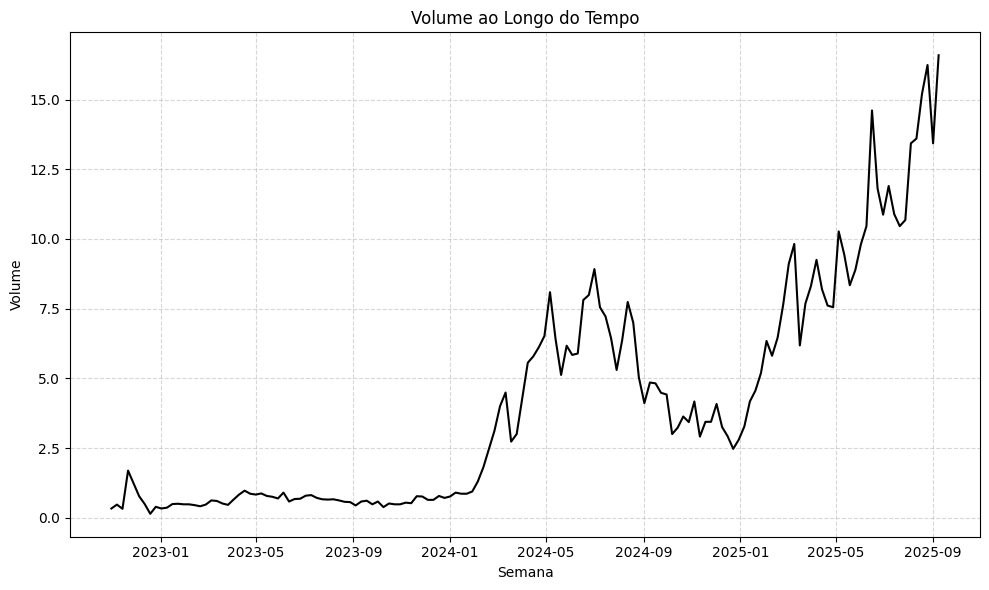

In [85]:
# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(prison["week"], prison["volume"], linestyle='-', marker='', color='black')

# Labels e título
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.title("Volume ao Longo do Tempo")

# Estilo minimalista
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Baselines

In [ ]:
# série semanal com frequência explícita
y = prison.sort_values("week").set_index("week")["volume"]
y = y.asfreq(pd.infer_freq(y.index) or "W")

h = 12  # horizonte
y_tr, y_te = y.iloc[:-h], y.iloc[-h:]
fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)

def fit_pred(strategy, sp=1):
    f = NaiveForecaster(strategy=strategy, sp=sp)
    f.fit(y_tr)
    return f.predict(fh)

preds = {
    "mean":  fit_pred("mean", sp=1),
    "naive": fit_pred("last", sp=1),
    "snaive": fit_pred("last", sp=h),   # sazonal
    "drift": fit_pred("drift", sp=1),
}

mase_metric = MeanAbsoluteScaledError(sp=h)

rows = []
for name, yhat in preds.items():
    rows.append({
        "model": name,
        "MAE":  mean_absolute_error(y_te, yhat),
        "RMSE": mean_squared_error(y_te, yhat, square_root=True),
        "MAPE_%": mean_absolute_percentage_error(y_te, yhat) * 100,
        "MASE": mase_metric(y_te, yhat, y_train=y_tr),
    })

metrics_sktime = pd.DataFrame(rows).sort_values("RMSE").round(3)
metrics_sktime

,model,MAE,RMSE,MAPE_%,MASE
1,naive,2.385,2.683,20.198,1.419
3,drift,2.582,2.976,22.252,1.536
2,snaive,3.531,3.932,26.753,2.101
0,mean,9.572,9.797,73.400,5.695


## Resíduos

In [87]:
residuos = {name: y_te - yhat for name, yhat in preds.items()}

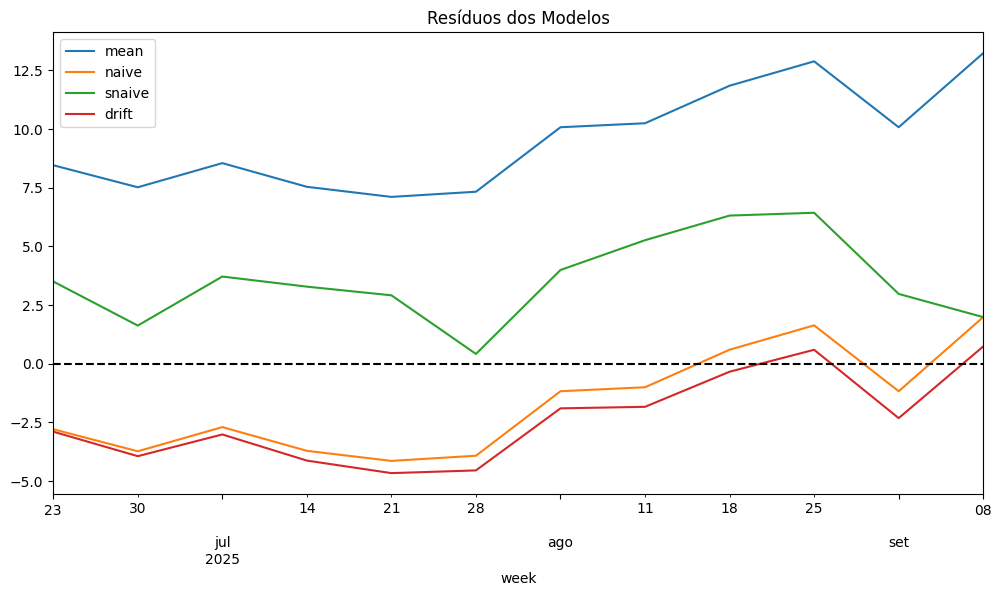

In [88]:
fig, ax = plt.subplots(figsize=(12, 6))

for name, res in residuos.items():
    res.plot(ax=ax, label=name)
    
ax.axhline(0, color="black", linestyle="--")
ax.set_title("Resíduos dos Modelos")
ax.legend()

plt.show()

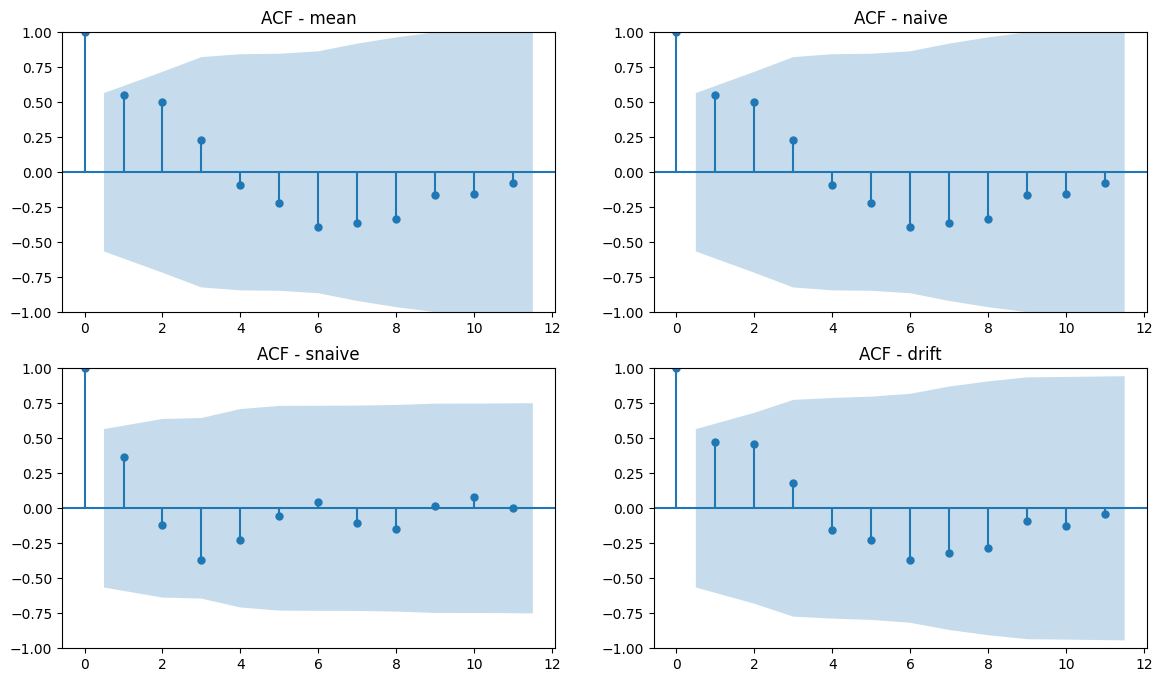

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for ax, (name, res) in zip(axes.flatten(), residuos.items()):
    plot_acf(res, lags=h-1, ax=ax)
    ax.set_title(f"ACF - {name}")

plt.show()

In [90]:
for name, res in residuos.items():
    lb_test = acorr_ljungbox(res, lags=[10], return_df=True)
    print(f"{name} - Ljung-Box p-value: {lb_test["lb_pvalue"].values[0]}")

mean - Ljung-Box p-value: 0.0018276169357567401
naive - Ljung-Box p-value: 0.0018276169357567319
snaive - Ljung-Box p-value: 0.6379537422252883
drift - Ljung-Box p-value: 0.01576504585359265


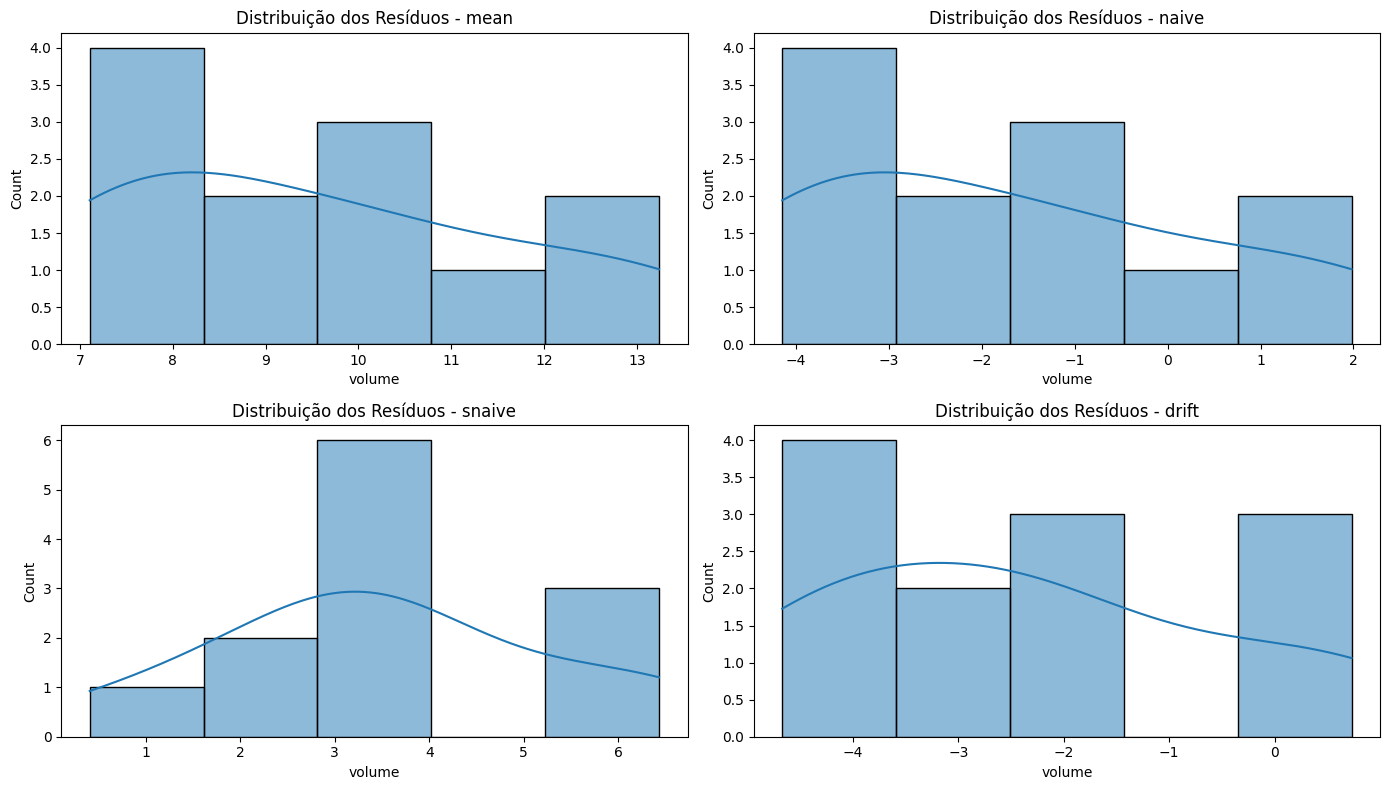

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for ax, (name, res) in zip(axes.flatten(), residuos.items()):
    sns.histplot(res, kde=True, ax=ax)
    ax.set_title(f"Distribuição dos Resíduos - {name}")
    
plt.tight_layout()
plt.show()

In [102]:
df = prison.copy()

In [114]:
prison["week_num"] = prison["week"].map(pd.Timestamp.toordinal)

X = prison[["week_num"]]
y = prison["volume"]

# h = 52

X_train, X_test = X.iloc[:-h], X.iloc[-h:]
y_train, y_test = y.iloc[:-h], y.iloc[-h:]

In [115]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [95]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1.5181786053740638
RMSE: 3.6403805903775144


In [96]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": model.coef_
}).sort_values("coef", key=abs, ascending=False)

print(coef_df)

           feature          coef
4             lag1  7.010913e-01
0             year  5.912435e-01
7   rolling_mean_4  4.489205e-01
5             lag2 -3.275583e-01
8  rolling_mean_12  2.274609e-01
6            lag52 -1.687630e-01
1            month  2.495783e-03
2       weekofyear -2.413535e-03
3        dayofweek -1.566455e-15


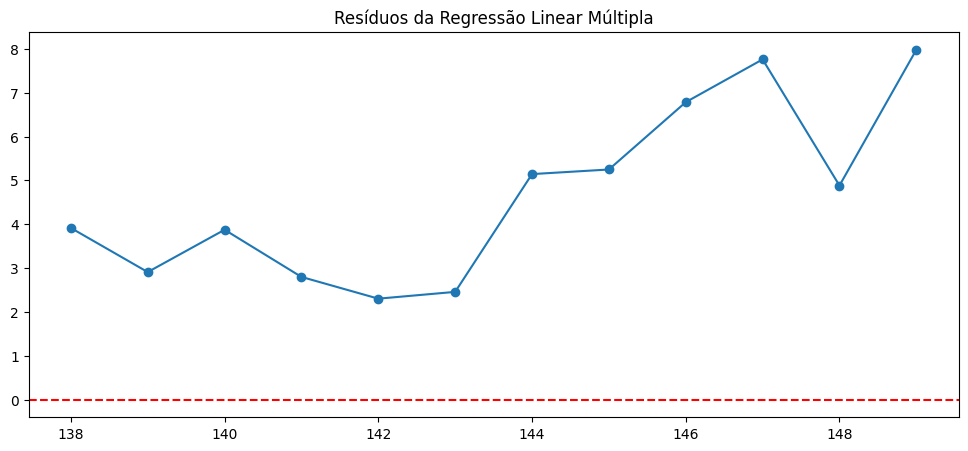

In [116]:
residuos = y_test - y_pred

plt.figure(figsize=(12,5))
plt.plot(residuos, marker="o")
plt.axhline(0, color="red", linestyle="--")
plt.title("Resíduos da Regressão Linear Múltipla")
plt.show()

In [122]:
f"R²: {r2_score(y_test, y_pred)}"

'R²: -4.841026097898585'

In [123]:
def r2_adjusted(y_test, y_pred):
    n, p = X_test.shape
    r2 = r2_score(y_test, y_pred)

    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [124]:
r2_adjusted(y_test, y_pred)

-5.425128707688444

In [128]:
import statsmodels.api as sm

# Adiciona intercepto
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_sm).fit()

y_pred = ols_model.predict(X_test_sm)

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     282.8
Date:                sex, 03 out 2025   Prob (F-statistic):           5.03e-35
Time:                        21:18:35   Log-Likelihood:                -277.30
No. Observations:                 138   AIC:                             558.6
Df Residuals:                     136   BIC:                             564.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6893.3332    410.107    -16.809      0.0